In [73]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")
import os
os.chdir('/Users/tsukasamiyaji/Desktop/Python3')
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from collections import Counter
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from mlxtend.frequent_patterns import apriori as ap, association_rules as ap_rl
from icecream import ic
from joblib import Parallel,delayed
from sklearn.neighbors import KNeighborsClassifier 

# Data Preparation

In [74]:
df = pd.read_csv('Fingerhut_modified.csv')
df = df.drop(['Unnamed: 0'],axis=1) 
pivot_table = pd.pivot_table(df, values='count', index='account_id', columns='ed_id',aggfunc='sum').fillna(0)
export_piv2 = pd.DataFrame(pivot_table)
export_piv2 = export_piv2.reset_index()
export_piv2.columns = ['account_id','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','26','27','28','29']
export_piv2.set_index('account_id',inplace=True)
export_piv2.head()


,1,2,3,4,5,6,7,8,9,10,...,19,20,21,22,23,24,26,27,28,29
account_id,,,,,,,,,,,,,,,,,,,,,
-2147477843,4.0,1.0,0.0,9.0,5.0,2.0,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
-2147476504,3.0,1.0,1.0,18.0,8.0,7.0,1.0,1.0,0.0,0.0,...,8.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
-2147476077,0.0,1.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-2147475397,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
-2147473858,2.0,0.0,2.0,8.0,3.0,1.0,0.0,0.0,0.0,0.0,...,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Classsification each account ID

In [76]:
# Are there any events that related to purchase or account activation?? 12,15??

cond1 = export_piv2['7'] > 0
cond2 = export_piv2['18'] > 0
cond3 = export_piv2['29'] > 0


#Purchase and Activate=0, Purchase and non-Activate=1, non-Purchase and non-Activate=2, non-Purchase and Activate=3
conditions  = [(cond1 | cond2) & (cond3), (cond1 | cond2) & ~(cond3), (~cond1 | ~cond2) & ~(cond3), (~cond1 | ~cond2) & (cond3)]
choices     = [0,1,2,3]


export_piv2["Condition"] = np.select(conditions, choices, default=np.nan)

export_piv2.head()

,1,2,3,4,5,6,7,8,9,10,...,20,21,22,23,24,26,27,28,29,Condition
account_id,,,,,,,,,,,,,,,,,,,,,
-2147477843,4.0,1.0,0.0,9.0,5.0,2.0,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
-2147476504,3.0,1.0,1.0,18.0,8.0,7.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
-2147476077,0.0,1.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
-2147475397,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
-2147473858,2.0,0.0,2.0,8.0,3.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [77]:
ids_to_remove = [7,18,29]
df = df[~df['ed_id'].isin(ids_to_remove)]
df.head()

,account_id,ed_id,event_name,Date,count
0,1773350293,12,application_web_approved,2023-03-22,1
1,1773350293,19,application_web_view,2023-03-22,13
2,1773350293,3,application_web_submit,2023-03-22,1
3,1773350293,2,campaign_click,2023-03-22,1
4,1773350293,19,application_web_view,2023-07-27,5


In [78]:
new_df = export_piv2[['Condition']]

filtered_df_head = df.groupby('account_id').head(10)

pivot_df = pd.pivot_table(filtered_df_head, values='ed_id', index='account_id', columns=filtered_df_head.groupby('account_id').cumcount() + 1, aggfunc='first').fillna(0)

final_df = pd.merge(pivot_df, new_df, on='account_id', how='left')

final_df.head()


,1,2,3,4,5,6,7,8,9,10,Condition
account_id,,,,,,,,,,,
-2147477843,2.0,12.0,1.0,4.0,11.0,5.0,6.0,4.0,11.0,5.0,0.0
-2147476504,2.0,4.0,11.0,5.0,6.0,19.0,3.0,12.0,1.0,11.0,0.0
-2147476077,19.0,3.0,12.0,4.0,2.0,4.0,4.0,4.0,4.0,0.0,2.0
-2147475397,12.0,22.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
-2147473858,4.0,12.0,1.0,3.0,11.0,4.0,5.0,19.0,6.0,11.0,2.0


# Prepare for Apriori

In [6]:
filtered_df_2 = df.groupby('account_id').head(10)


pivot_table2 = pd.pivot_table(filtered_df_2, values='count', index='account_id', columns='ed_id').fillna(0)

export_piv3 = pd.DataFrame(pivot_table2)
export_piv3 = export_piv3.reset_index()

export_piv3.columns = ['account_id','1','2','3','4','5','6','8','9','10','11','12','13','14','15','16','17','19','20','21','22','23','24','26','27','28']

exclude_column = 'account_id'
export_piv3 = export_piv3.apply(lambda x: x if x.name == exclude_column else (x > 0).astype(int), axis=0)

export_piv3.head()



,account_id,1,2,3,4,5,6,8,9,10,...,17,19,20,21,22,23,24,26,27,28
0,-2147477843,1,1,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-2147476504,1,1,1,1,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,-2147476077,0,1,1,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,-2147475397,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,-2147473858,1,0,1,1,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0


# XGBoost classification

In [7]:
X, y = final_df.drop(['Condition'], axis=1), final_df[['Condition']]


In [9]:
for col in range(0,10):
   X.iloc[:,col] = X.iloc[:,col].astype('category')

X.dtypes

1     category
2     category
3     category
4     category
5     category
6     category
7     category
8     category
9     category
10    category
dtype: object

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=42)


In [11]:
dtrain_clf = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_clf = xgb.DMatrix(X_test, y_test, enable_categorical=True)


In [12]:
# Train a model
xgb_classifier = xgb.XGBClassifier(n_estimators=100, objective='multi:softprob', tree_method='hist', eta=0.1, max_depth=4, enable_categorical=True)
xgb_classifier.fit(X_train, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [13]:
# make predictions for test data
y_pred = xgb_classifier.predict(X_test)
xgb_prediction = [round(value) for value in y_pred]


In [15]:
sum(xgb_prediction == y_test['Condition'])/len(xgb_prediction)

0.8288618963656129

In [16]:
from collections import Counter

# Sample numeric vector
numeric_vector = xgb_prediction

# Count the occurrences of each element
element_counts = Counter(numeric_vector)

# Print the result
print("Number of Each Element:")
for element, count in element_counts.items():
    print(f"{element}: {count}")

Number of Each Element:
2: 472158
0: 46275
3: 839
1: 1366


In [17]:
from collections import Counter

# Sample numeric vector
numeric_vector = y_test['Condition']

# Count the occurrences of each element
element_counts = Counter(numeric_vector)

# Print the result
print("Number of Each Element:")
for element, count in element_counts.items():
    print(f"{element}: {count}")

Number of Each Element:
2.0: 387774
3.0: 17579
0.0: 107392
1.0: 7893


In [18]:
xgb_df = pd.concat([X_test,y_test],axis=1)
xgb_df = xgb_df.reset_index()
xgb_df

,account_id,1,2,3,4,5,6,7,8,9,10,Condition
0,1386482558,2.0,19.0,3.0,12.0,4.0,11.0,1.0,4.0,11.0,1.0,2.0
1,613555242,12.0,1.0,11.0,6.0,5.0,6.0,5.0,0.0,0.0,0.0,2.0
2,-733153014,2.0,22.0,12.0,4.0,11.0,5.0,6.0,19.0,19.0,1.0,2.0
3,1815715206,2.0,12.0,4.0,11.0,5.0,1.0,4.0,1.0,1.0,1.0,2.0
4,-1129680779,2.0,12.0,4.0,11.0,5.0,6.0,1.0,5.0,4.0,11.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
520633,-678008749,1.0,19.0,3.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
520634,70215549,12.0,4.0,11.0,1.0,5.0,2.0,1.0,21.0,1.0,1.0,2.0
520635,893939713,19.0,3.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
520636,191932869,15.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [19]:
xgb_prediction_df = pd.DataFrame(xgb_prediction)
xgb_df = pd.concat([xgb_df,xgb_prediction_df],axis=1)
xgb_df

,account_id,1,2,3,4,5,6,7,8,9,10,Condition,0
0,1386482558,2.0,19.0,3.0,12.0,4.0,11.0,1.0,4.0,11.0,1.0,2.0,2
1,613555242,12.0,1.0,11.0,6.0,5.0,6.0,5.0,0.0,0.0,0.0,2.0,2
2,-733153014,2.0,22.0,12.0,4.0,11.0,5.0,6.0,19.0,19.0,1.0,2.0,2
3,1815715206,2.0,12.0,4.0,11.0,5.0,1.0,4.0,1.0,1.0,1.0,2.0,2
4,-1129680779,2.0,12.0,4.0,11.0,5.0,6.0,1.0,5.0,4.0,11.0,3.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
520633,-678008749,1.0,19.0,3.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2
520634,70215549,12.0,4.0,11.0,1.0,5.0,2.0,1.0,21.0,1.0,1.0,2.0,2
520635,893939713,19.0,3.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2
520636,191932869,15.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1


In [22]:
xgb_df_sm = xgb_df[xgb_df['Condition'] == xgb_df[0]]
xgb_df_sm

,account_id,1,2,3,4,5,6,7,8,9,10,Condition,0
0,1386482558,2.0,19.0,3.0,12.0,4.0,11.0,1.0,4.0,11.0,1.0,2.0,2
1,613555242,12.0,1.0,11.0,6.0,5.0,6.0,5.0,0.0,0.0,0.0,2.0,2
2,-733153014,2.0,22.0,12.0,4.0,11.0,5.0,6.0,19.0,19.0,1.0,2.0,2
3,1815715206,2.0,12.0,4.0,11.0,5.0,1.0,4.0,1.0,1.0,1.0,2.0,2
7,903888710,1.0,1.0,4.0,5.0,1.0,19.0,3.0,12.0,4.0,4.0,2.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
520633,-678008749,1.0,19.0,3.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2
520634,70215549,12.0,4.0,11.0,1.0,5.0,2.0,1.0,21.0,1.0,1.0,2.0,2
520635,893939713,19.0,3.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2
520636,191932869,15.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1


In [28]:
xgb_df_sm_0 = xgb_df_sm[xgb_df_sm['Condition'] == 0]
xgb_df_sm_1 = xgb_df_sm[xgb_df_sm['Condition'] == 1]
xgb_df_sm_2 = xgb_df_sm[xgb_df_sm['Condition'] == 2]
xgb_df_sm_3 = xgb_df_sm[xgb_df_sm['Condition'] == 3]

xgb_df_sm_00 = xgb_df_sm_0.drop(['Condition',0],axis=1)
xgb_df_sm_11 = xgb_df_sm_1.drop(['Condition',0],axis=1)
xgb_df_sm_22 = xgb_df_sm_2.drop(['Condition',0],axis=1)
xgb_df_sm_33 = xgb_df_sm_3.drop(['Condition',0],axis=1)


In [30]:
apg_df_0 = pd.merge(xgb_df_sm_00['account_id'], export_piv3, on='account_id', how='left')
apg_df_1 = pd.merge(xgb_df_sm_11['account_id'], export_piv3, on='account_id', how='left')
apg_df_2 = pd.merge(xgb_df_sm_22['account_id'], export_piv3, on='account_id', how='left')
apg_df_3 = pd.merge(xgb_df_sm_33['account_id'], export_piv3, on='account_id', how='left')

apg_df_00 = apg_df_0.drop(['account_id'],axis=1)
apg_df_11 = apg_df_1.drop(['account_id'],axis=1)
apg_df_22 = apg_df_2.drop(['account_id'],axis=1)
apg_df_33 = apg_df_3.drop(['account_id'],axis=1)

# K-means

In [37]:
final_df_drop = final_df.reset_index()
final_df_drop = final_df_drop.drop(['Condition'],axis=1)
final_df_drop1 = final_df_drop.drop(['account_id'],axis=1)

In [38]:
final_df_drop

,account_id,1,2,3,4,5,6,7,8,9,10
0,-2147477843,2.0,12.0,1.0,4.0,11.0,5.0,6.0,4.0,11.0,5.0
1,-2147476504,2.0,4.0,11.0,5.0,6.0,19.0,3.0,12.0,1.0,11.0
2,-2147476077,19.0,3.0,12.0,4.0,2.0,4.0,4.0,4.0,4.0,0.0
3,-2147475397,12.0,22.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-2147473858,4.0,12.0,1.0,3.0,11.0,4.0,5.0,19.0,6.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...
1735452,2147469625,19.0,3.0,13.0,12.0,4.0,11.0,5.0,6.0,8.0,2.0
1735453,2147475185,22.0,2.0,12.0,4.0,11.0,1.0,5.0,6.0,1.0,24.0
1735454,2147476319,19.0,3.0,2.0,19.0,3.0,12.0,4.0,4.0,1.0,19.0
1735455,2147478805,12.0,4.0,11.0,5.0,6.0,6.0,4.0,24.0,4.0,11.0


In [39]:
final_array = final_df_drop1.to_numpy()

In [40]:
final_array


array([[ 2., 12.,  1., ...,  4., 11.,  5.],
       [ 2.,  4., 11., ..., 12.,  1., 11.],
       [19.,  3., 12., ...,  4.,  4.,  0.],
       ...,
       [19.,  3.,  2., ...,  4.,  1., 19.],
       [12.,  4., 11., ..., 24.,  4., 11.],
       [12.,  4.,  2., ...,  0.,  0.,  0.]])

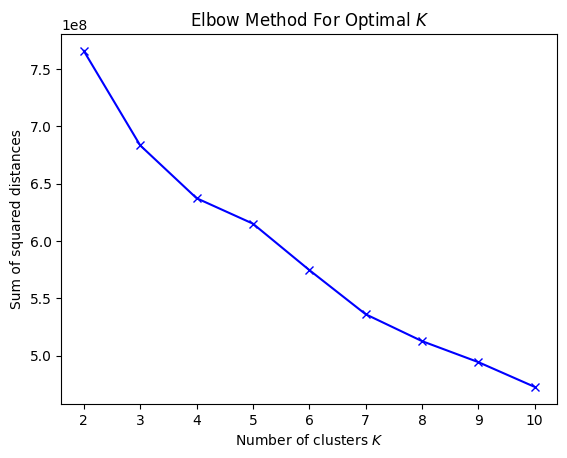

In [41]:
# Search for "optimal" number of clusters
SS_dist = []
K = range(2,11)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters,n_init='auto')
    kmeans.fit(final_array)
    SS_dist.append(kmeans.inertia_)
plt.plot(K,SS_dist,'bx-')
plt.xlabel('Number of clusters $K$') 
plt.ylabel('Sum of squared distances') 
plt.title('Elbow Method For Optimal $K$')
plt.show()

In [42]:
# Sklearn implementation of K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=0).fit(final_array)
Partition_vec = kmeans.labels_
Partition_vec

array([2, 3, 1, ..., 3, 3, 1], dtype=int32)

In [43]:
kmeans_condition = pd.DataFrame(Partition_vec, columns=['kmeans_condition'])

In [44]:
kmeans_df = pd.concat([final_df_drop,kmeans_condition['kmeans_condition']],axis=1)
                       
                       

In [45]:
kmeans_df

,account_id,1,2,3,4,5,6,7,8,9,10,kmeans_condition
0,-2147477843,2.0,12.0,1.0,4.0,11.0,5.0,6.0,4.0,11.0,5.0,2
1,-2147476504,2.0,4.0,11.0,5.0,6.0,19.0,3.0,12.0,1.0,11.0,3
2,-2147476077,19.0,3.0,12.0,4.0,2.0,4.0,4.0,4.0,4.0,0.0,1
3,-2147475397,12.0,22.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,-2147473858,4.0,12.0,1.0,3.0,11.0,4.0,5.0,19.0,6.0,11.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1735452,2147469625,19.0,3.0,13.0,12.0,4.0,11.0,5.0,6.0,8.0,2.0,1
1735453,2147475185,22.0,2.0,12.0,4.0,11.0,1.0,5.0,6.0,1.0,24.0,3
1735454,2147476319,19.0,3.0,2.0,19.0,3.0,12.0,4.0,4.0,1.0,19.0,3
1735455,2147478805,12.0,4.0,11.0,5.0,6.0,6.0,4.0,24.0,4.0,11.0,3


In [46]:
kmeans_df_0 = kmeans_df[kmeans_df['kmeans_condition'] == 0]
kmeans_df_1 = kmeans_df[kmeans_df['kmeans_condition'] == 1]
kmeans_df_2 = kmeans_df[kmeans_df['kmeans_condition'] == 2]
kmeans_df_3 = kmeans_df[kmeans_df['kmeans_condition'] == 3]


kmeans_df_00 = kmeans_df_0.drop(['kmeans_condition'],axis=1)
kmeans_df_11 = kmeans_df_1.drop(['kmeans_condition'],axis=1)
kmeans_df_22 = kmeans_df_2.drop(['kmeans_condition'],axis=1)
kmeans_df_33 = kmeans_df_3.drop(['kmeans_condition'],axis=1)


In [47]:
ap_df_0 = pd.merge(kmeans_df_00['account_id'], export_piv3, on='account_id', how='left')
ap_df_1 = pd.merge(kmeans_df_11['account_id'], export_piv3, on='account_id', how='left')
ap_df_2 = pd.merge(kmeans_df_22['account_id'], export_piv3, on='account_id', how='left')
ap_df_3 = pd.merge(kmeans_df_33['account_id'], export_piv3, on='account_id', how='left')

ap_df_00 = ap_df_0.drop(['account_id'],axis=1)
ap_df_11 = ap_df_1.drop(['account_id'],axis=1)
ap_df_22 = ap_df_2.drop(['account_id'],axis=1)
ap_df_33 = ap_df_3.drop(['account_id'],axis=1)


# Apriori algorithm

## K-means output

In [48]:
# NOTE TODO:PARAMETERS OF APRIORI ALGORITHM

# support - % of how often each item appears
supp_thresh = 0.05

# confidence


# lift
lift_thresh = 0.8

# FILTER THRESHOLD FOR # OF ITEMS IN SET (threshold INCLUDES the given value)
n_item_thresh = 3

# sort by columns
filter_cols = ["lift"]

In [49]:
# APRIORI ALGORITHM

ap_set = ap(ap_df_00, min_support=supp_thresh, use_colnames=True)
rules = ap_rl(ap_set, metric = "lift", min_threshold= lift_thresh)

# vectorize length func
v_len = np.vectorize(len)

# use it for condition in rule filtering
cond_0h = v_len(rules.antecedents.values) >= n_item_thresh
cond_0t = v_len(rules.consequents.values) >= n_item_thresh

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [50]:
# filter rules 
rules[cond_0h].sort_values(by = filter_cols, ascending = False).head(10)



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
24443,"(6, 27, 5, 4)","(8, 28, 11)",0.102298,0.062208,0.061939,0.605474,9.733013,0.055575,2.377011,0.999505
24466,"(8, 28, 11)","(6, 27, 5, 4)",0.062208,0.102298,0.061939,0.995672,9.733013,0.055575,207.413948,0.956776
25499,"(8, 28, 12, 11)","(6, 27, 5, 4)",0.061463,0.102298,0.061194,0.995619,9.732500,0.054907,204.930307,0.956011
25546,"(6, 27, 5, 4)","(8, 28, 12, 11)",0.102298,0.061463,0.061194,0.598193,9.732500,0.054907,2.335788,0.999499
25496,"(28, 6, 12, 11)","(8, 27, 5, 4)",0.064017,0.098287,0.061194,0.955909,9.725720,0.054902,20.451258,0.958543
25549,"(8, 27, 5, 4)","(28, 6, 12, 11)",0.098287,0.064017,0.061194,0.622609,9.725720,0.054902,2.480141,0.994972
25590,"(8, 28, 11)","(12, 4, 6, 27, 5)",0.062208,0.101217,0.061194,0.983698,9.718702,0.054898,55.131987,0.956615
25455,"(12, 4, 6, 27, 5)","(8, 28, 11)",0.101217,0.062208,0.061194,0.604584,9.718702,0.054898,2.371659,0.998134
25460,"(12, 4, 8, 5, 28)","(6, 27, 11)",0.064766,0.097286,0.061194,0.944849,9.712067,0.054893,16.367928,0.959156
25585,"(6, 27, 11)","(12, 4, 8, 5, 28)",0.097286,0.064766,0.061194,0.629013,9.712067,0.054893,2.520934,0.993709


In [51]:
# APRIORI ALGORITHM

ap_set = ap(ap_df_11, min_support=supp_thresh, use_colnames=True)
rules = ap_rl(ap_set, metric = "lift", min_threshold= lift_thresh)

# vectorize length func
v_len = np.vectorize(len)

# use it for condition in rule filtering
cond_1h = v_len(rules.antecedents.values) >= n_item_thresh
cond_1t = v_len(rules.consequents.values) >= n_item_thresh


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [52]:
# filter rules 
rules[cond_1h].sort_values(by = filter_cols, ascending = False).head(10)



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
13067,"(3, 5, 11)","(19, 6, 12, 4)",0.213439,0.164040,0.141057,0.660875,4.028756,0.106044,2.465054,0.955786
13050,"(19, 6, 12, 4)","(3, 5, 11)",0.164040,0.213439,0.141057,0.859893,4.028756,0.106044,5.614011,0.899306
10015,"(19, 6, 4)","(3, 5, 11)",0.165848,0.213439,0.142387,0.858538,4.022405,0.106988,5.560216,0.900786
10002,"(3, 5, 11)","(19, 6, 4)",0.213439,0.165848,0.142387,0.667107,4.022405,0.106988,2.505768,0.955288
13090,"(19, 6, 4)","(3, 5, 12, 11)",0.165848,0.211607,0.141057,0.850518,4.019333,0.105962,5.274152,0.900558
13027,"(3, 5, 12, 11)","(19, 6, 4)",0.211607,0.165848,0.141057,0.666598,4.019333,0.105962,2.501939,0.952827
13453,"(12, 4, 19, 6, 1)","(3, 5, 11)",0.131475,0.213439,0.112754,0.857612,4.018067,0.084693,5.524063,0.864827
13552,"(3, 5, 11)","(12, 4, 19, 6, 1)",0.213439,0.131475,0.112754,0.528275,4.018067,0.084693,1.841167,0.954947
11412,"(19, 6, 1, 4)","(3, 5, 11)",0.133025,0.213439,0.113929,0.856451,4.012627,0.085537,5.479376,0.865984
11429,"(3, 5, 11)","(19, 6, 1, 4)",0.213439,0.133025,0.113929,0.533780,4.012627,0.085537,1.859582,0.954518


In [53]:
# APRIORI ALGORITHM

ap_set = ap(ap_df_22, min_support=supp_thresh, use_colnames=True)
rules = ap_rl(ap_set, metric = "lift", min_threshold= lift_thresh)

# vectorize length func
v_len = np.vectorize(len)

# use it for condition in rule filtering
cond_2h = v_len(rules.antecedents.values) >= n_item_thresh
cond_2t = v_len(rules.consequents.values) >= n_item_thresh

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [54]:
# filter rules 
rules[cond_2h].sort_values(by = filter_cols, ascending = False).head(10)



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
18304,"(3, 6, 2, 4)","(19, 5, 12, 11)",0.113827,0.249727,0.102574,0.901147,3.608520,0.074149,7.589743,0.815730
18329,"(19, 5, 12, 11)","(3, 6, 2, 4)",0.249727,0.113827,0.102574,0.410745,3.608520,0.074149,1.503889,0.963487
18233,"(3, 12, 4, 6, 2)","(19, 5, 11)",0.112746,0.253627,0.102574,0.909783,3.587085,0.073979,8.273049,0.812870
18400,"(19, 5, 11)","(3, 12, 4, 6, 2)",0.253627,0.112746,0.102574,0.404430,3.587085,0.073979,1.489755,0.966303
15315,"(3, 6, 2, 4)","(19, 5, 11)",0.113827,0.253627,0.103490,0.909189,3.584745,0.074620,8.218969,0.813656
15370,"(19, 5, 11)","(3, 6, 2, 4)",0.253627,0.113827,0.103490,0.408039,3.584745,0.074620,1.497014,0.966059
18310,"(3, 6, 2, 11)","(19, 5, 12, 4)",0.107532,0.266724,0.102574,0.953900,3.576359,0.073893,15.906105,0.807184
18323,"(19, 5, 12, 4)","(3, 6, 2, 11)",0.266724,0.107532,0.102574,0.384572,3.576359,0.073893,1.450158,0.982421
18773,"(19, 5, 12, 11)","(3, 4, 6, 2, 1)",0.249727,0.084208,0.074980,0.300249,3.565571,0.053951,1.308740,0.959038
18624,"(3, 4, 6, 2, 1)","(19, 5, 12, 11)",0.084208,0.249727,0.074980,0.890421,3.565571,0.053951,6.846861,0.785702


In [55]:
# APRIORI ALGORITHM

ap_set = ap(ap_df_33, min_support=supp_thresh, use_colnames=True)
rules = ap_rl(ap_set, metric = "lift", min_threshold= lift_thresh)

# vectorize length func
v_len = np.vectorize(len)

# use it for condition in rule filtering
cond_3h = v_len(rules.antecedents.values) >= n_item_thresh
cond_3t = v_len(rules.consequents.values) >= n_item_thresh

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [56]:
# filter rules 
rules[cond_3h].sort_values(by = filter_cols, ascending = False).head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
50388,"(12, 11, 19, 6, 27)","(8, 3, 5, 4)",0.081261,0.087775,0.070242,0.864396,9.847812,0.063109,6.727143,0.977921
50457,"(8, 3, 5, 4)","(12, 11, 19, 6, 27)",0.087775,0.081261,0.070242,0.800242,9.847812,0.063109,4.599258,0.984905
48241,"(8, 3, 5, 4)","(19, 6, 27, 11)",0.087775,0.081441,0.070323,0.801169,9.837375,0.063174,4.619799,0.984787
48284,"(19, 6, 27, 11)","(8, 3, 5, 4)",0.081441,0.087775,0.070323,0.863480,9.837375,0.063174,6.682001,0.977996
50310,"(3, 12, 4, 8, 5)","(19, 6, 27, 11)",0.087676,0.081441,0.070242,0.801146,9.837094,0.063101,4.619267,0.984677
50535,"(19, 6, 27, 11)","(3, 12, 4, 8, 5)",0.081441,0.087676,0.070242,0.862481,9.837094,0.063101,6.634164,0.977993
50564,"(8, 3, 11)","(12, 4, 19, 6, 27, 5)",0.085005,0.084028,0.070242,0.826326,9.833925,0.063099,5.274084,0.981766
50281,"(12, 4, 19, 6, 27, 5)","(8, 3, 11)",0.084028,0.085005,0.070242,0.835930,9.833925,0.063099,5.576868,0.980719
50431,"(8, 3, 12, 11)","(4, 19, 6, 27, 5)",0.084902,0.084219,0.070242,0.827325,9.823472,0.063091,5.303483,0.981538
50414,"(4, 19, 6, 27, 5)","(8, 3, 12, 11)",0.084219,0.084902,0.070242,0.834034,9.823472,0.063091,5.513754,0.980806


## XGBoost output

In [57]:
# NOTE TODO:PARAMETERS OF APRIORI ALGORITHM

# support - % of how often each item appears
supp_thresh = 0.05

# confidence


# lift
lift_thresh = 0.8

# FILTER THRESHOLD FOR # OF ITEMS IN SET (threshold INCLUDES the given value)
n_item_thresh = 3

# sort by columns
filter_cols = ["lift"]

In [58]:
# APRIORI ALGORITHM

ap_set = ap(apg_df_00, min_support=supp_thresh, use_colnames=True)
rules = ap_rl(ap_set, metric = "lift", min_threshold= lift_thresh)

# vectorize length func
v_len = np.vectorize(len)

# use it for condition in rule filtering
cond_0h = v_len(rules.antecedents.values) >= n_item_thresh
cond_0t = v_len(rules.consequents.values) >= n_item_thresh

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [59]:
# filter rules 
rules[cond_0h].sort_values(by = filter_cols, ascending = False).head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
71413,"(3, 6, 27)","(8, 19, 12, 28)",0.185100,0.060815,0.051824,0.279975,4.603687,0.040567,1.304378,0.960588
71398,"(8, 19, 12, 28)","(3, 6, 27)",0.060815,0.185100,0.051824,0.852144,4.603687,0.040567,5.511458,0.833471
44098,"(8, 19, 28)","(3, 6, 27)",0.060976,0.185100,0.051915,0.851407,4.599703,0.040628,5.484109,0.833413
44089,"(3, 6, 27)","(8, 19, 28)",0.185100,0.060976,0.051915,0.280470,4.599703,0.040628,1.305052,0.960357
71380,"(3, 6, 27, 12)","(8, 19, 28)",0.184803,0.060976,0.051824,0.280426,4.598985,0.040555,1.304972,0.959965
71431,"(8, 19, 28)","(3, 6, 27, 12)",0.060976,0.184803,0.051824,0.849906,4.598985,0.040555,5.431250,0.833376
71396,"(19, 6, 12, 28)","(8, 3, 27)",0.062737,0.181943,0.051824,0.826039,4.540100,0.040409,4.702542,0.831934
71415,"(8, 3, 27)","(19, 6, 12, 28)",0.181943,0.062737,0.051824,0.284834,4.540100,0.040409,1.310553,0.953162
44096,"(19, 6, 28)","(8, 3, 27)",0.063012,0.181943,0.051915,0.823893,4.528301,0.040450,4.645214,0.831565
44091,"(8, 3, 27)","(19, 6, 28)",0.181943,0.063012,0.051915,0.285337,4.528301,0.040450,1.311091,0.952460


In [60]:
# APRIORI ALGORITHM

ap_set = ap(apg_df_11, min_support=supp_thresh, use_colnames=True)
rules = ap_rl(ap_set, metric = "lift", min_threshold= lift_thresh)

# vectorize length func
v_len = np.vectorize(len)

# use it for condition in rule filtering
cond_1h = v_len(rules.antecedents.values) >= n_item_thresh
cond_1t = v_len(rules.consequents.values) >= n_item_thresh

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [61]:
# filter rules 
rules[cond_1h].sort_values(by = filter_cols, ascending = False).head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
5887,"(19, 6, 1, 11)","(3, 5)",0.083434,0.061669,0.061669,0.73913,11.985507,0.056523,3.596937,1.000000
5888,"(1, 19, 6, 5)","(3, 11)",0.083434,0.061669,0.061669,0.73913,11.985507,0.056523,3.596937,1.000000
5895,"(1, 3, 5)","(19, 6, 11)",0.061669,0.083434,0.061669,1.00000,11.985507,0.056523,inf,0.976804
7416,"(19, 6, 1, 4)","(3, 5, 11)",0.083434,0.061669,0.061669,0.73913,11.985507,0.056523,3.596937,1.000000
7418,"(19, 5, 1, 4)","(3, 6, 11)",0.083434,0.061669,0.061669,0.73913,11.985507,0.056523,3.596937,1.000000
5894,"(3, 6, 5)","(19, 1, 11)",0.061669,0.083434,0.061669,1.00000,11.985507,0.056523,inf,0.976804
7420,"(19, 6, 1, 11)","(3, 5, 4)",0.083434,0.061669,0.061669,0.73913,11.985507,0.056523,3.596937,1.000000
7421,"(19, 6, 5, 11)","(3, 1, 4)",0.083434,0.061669,0.061669,0.73913,11.985507,0.056523,3.596937,1.000000
7422,"(19, 5, 1, 11)","(3, 6, 4)",0.083434,0.061669,0.061669,0.73913,11.985507,0.056523,3.596937,1.000000
7424,"(19, 6, 1, 5)","(11, 3, 4)",0.083434,0.061669,0.061669,0.73913,11.985507,0.056523,3.596937,1.000000


In [62]:
# APRIORI ALGORITHM

ap_set = ap(apg_df_22, min_support=supp_thresh, use_colnames=True)
rules = ap_rl(ap_set, metric = "lift", min_threshold= lift_thresh)

# vectorize length func
v_len = np.vectorize(len)

# use it for condition in rule filtering
cond_2h = v_len(rules.antecedents.values) >= n_item_thresh
cond_2t = v_len(rules.consequents.values) >= n_item_thresh

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [63]:
# filter rules 
rules[cond_2h].sort_values(by = filter_cols, ascending = False).head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
15421,"(3, 5, 11)","(19, 6, 12, 4)",0.165237,0.129040,0.104041,0.629647,4.879487,0.082719,2.351704,0.952438
15404,"(19, 6, 12, 4)","(3, 5, 11)",0.129040,0.165237,0.104041,0.806271,4.879487,0.082719,4.308923,0.912855
11865,"(19, 6, 4)","(3, 5, 11)",0.131307,0.165237,0.105454,0.803111,4.860362,0.083758,4.239764,0.914309
11852,"(3, 5, 11)","(19, 6, 4)",0.165237,0.131307,0.105454,0.638201,4.860362,0.083758,2.401036,0.951472
15381,"(3, 5, 12, 11)","(19, 6, 4)",0.163288,0.131307,0.104041,0.637164,4.852462,0.082600,2.394171,0.948855
15444,"(19, 6, 4)","(3, 5, 12, 11)",0.131307,0.163288,0.104041,0.792347,4.852462,0.082600,4.029374,0.913924
16158,"(3, 5, 11)","(12, 4, 19, 6, 1)",0.165237,0.108677,0.086912,0.525983,4.839862,0.068954,1.880359,0.950428
16059,"(12, 4, 19, 6, 1)","(3, 5, 11)",0.108677,0.165237,0.086912,0.799724,4.839862,0.068954,4.168057,0.890118
16104,"(3, 5, 1, 11)","(19, 6, 12, 4)",0.139635,0.129040,0.086912,0.622421,4.823486,0.068893,2.306696,0.921331
16113,"(19, 6, 12, 4)","(3, 5, 1, 11)",0.129040,0.139635,0.086912,0.673528,4.823486,0.068893,2.635337,0.910123


In [64]:
# APRIORI ALGORITHM

ap_set = ap(apg_df_33, min_support=supp_thresh, use_colnames=True)
rules = ap_rl(ap_set, metric = "lift", min_threshold= lift_thresh)

# vectorize length func
v_len = np.vectorize(len)

# use it for condition in rule filtering
cond_3h = v_len(rules.antecedents.values) >= n_item_thresh
cond_3t = v_len(rules.consequents.values) >= n_item_thresh

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [65]:
# filter rules 
rules[cond_3h].sort_values(by = filter_cols, ascending = False).head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
384,"(2, 12, 28)",(22),0.163352,0.052557,0.052557,0.321739,6.121739,0.043972,1.396871,1.000000
692,"(27, 2, 28)","(22, 12)",0.163352,0.052557,0.052557,0.321739,6.121739,0.043972,1.396871,1.000000
425,"(27, 2, 28)",(22),0.163352,0.052557,0.052557,0.321739,6.121739,0.043972,1.396871,1.000000
682,"(27, 2, 12, 28)",(22),0.163352,0.052557,0.052557,0.321739,6.121739,0.043972,1.396871,1.000000
691,"(2, 12, 28)","(27, 22)",0.163352,0.052557,0.052557,0.321739,6.121739,0.043972,1.396871,1.000000
683,"(27, 22, 12)","(2, 28)",0.052557,0.163352,0.052557,1.000000,6.121739,0.043972,inf,0.883058
689,"(27, 2, 12)","(22, 28)",0.187500,0.052557,0.052557,0.280303,5.333333,0.042702,1.316447,1.000000
369,"(27, 2, 12)",(22),0.187500,0.052557,0.052557,0.280303,5.333333,0.042702,1.316447,1.000000
370,"(27, 22, 12)",(2),0.052557,0.187500,0.052557,1.000000,5.333333,0.042702,inf,0.857571
385,"(22, 12, 28)",(2),0.052557,0.187500,0.052557,1.000000,5.333333,0.042702,inf,0.857571


# KNN

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


In [67]:
knn = KNeighborsClassifier(n_neighbors=4) 
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [68]:
# Predict on dataset which model has not seen before 
prediction = knn.predict(X_test)

In [69]:
knn.score(X_test, y_test)

0.7893031242437164